In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import eli5
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from eli5.sklearn import PermutationImportance

full_data = pd.read_csv("Results/clean_selection_2024_match.csv")

In [3]:
full_data.target

0           DS_E_coli
1           DS_E_coli
2           DS_E_coli
3           DS_E_coli
4           DS_E_coli
             ...     
38499    VSE_faecalis
38500    VSE_faecalis
38501    VSE_faecalis
38502    VSE_faecalis
38503    VSE_faecalis
Name: target, Length: 38504, dtype: object

In [4]:
target_subset = full_data[full_data.target == "MSSA"]
data = target_subset[['group_binary', 'intervening_patients_count', 'MRSA_col_pressure_score',
                                   'VRE_col_pressure_score', 'ESBL_col_pressure_score',
                                   'MSSA_col_pressure_score', 'VSE_col_pressure_score', 'DS_Enterobacterales_col_pressure_score', 
                                   'DS_P_aeruginosa_col_pressure_score', 'DR_P_aeruginosa_col_pressure_score', 'AdmitSourceDSC']]

In [5]:
data.shape

(2826, 11)

In [6]:
data = target_subset[["group_binary", "age", "any_abx_0_60", 
                      "any_abx_60_plus", "days_since_pathogen_dts_out_tier", "indiv_score"]]

In [19]:
# shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# one-hot encode non-numeric data
data = pd.get_dummies(data)

# split into train and test sets
X = data.drop(columns=["group_binary"])
y = data["group_binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# calculate the scale_pos_weight value
neg, pos = np.bincount(data["group_binary"])
scale_pos_weight = neg/pos

# fit model
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", max_depth=6, eta=0.01, subsample=0.5, colsample_bytree=0.5, min_child_weight=1, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="auc", early_stopping_rounds=10, verbose=10)

[0]	validation_0-auc:0.47625
[10]	validation_0-auc:0.61688
[13]	validation_0-auc:0.62839


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eta=0.01, eval_metric='auc', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=96, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.6511627906976742, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

AUC: 0.65


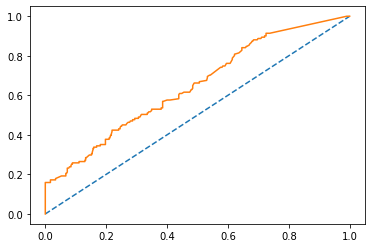

In [21]:
# evaluate model with AUC
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % auc)

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='')
plt.show()

In [22]:
# create a table of feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# view the table in publication ready style that looks nice, dropping all features with importance 0
importances[importances["importance"] > 0].style.background_gradient(cmap='Blues')

In [23]:
# find the permutation importances
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
# show the permutation importances
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [11]:
# partial dependence plots
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.tolist(), feature='MSSA_col_pressure_score')
pdp.pdp_plot(pdp_goals, 'feature value')
plt.show()

ValueError: feature does not exist: MSSA_col_pressure_score

In [ ]:
# SHAP values analysis
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.dependence_plot("intervening_patients_count", shap_values, X_test)
shap.dependence_plot("MSSA_col_pressure_score", shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test, alpha=.6, plot_size=(20,10))

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:])

In [ ]:
X_test.iloc[3,:]

In [ ]:
X_test

intervening_patients_count  MRSA_col_pressure_score  \
801                            0                 0.000000   
894                            0                 0.000000   
2327                          28                 3.209790   
2017                           0                 1.914880   
911                           98                 1.230799   
...                          ...                      ...   
1998                         180                 2.926295   
1813                           0                 0.042708   
1269                         133                 1.211401   
1417                           0                 0.000000   
2590                           0                 0.747073   

      VRE_col_pressure_score  ESBL_col_pressure_score  \
801                 0.000000                 0.000000   
894                 0.000000                 0.000000   
2327                2.223849                11.753351   
2017                0.000000                 0.000000   
911                 0.133219                 5.859592   
...                      ...                      ...   
1998                3.326608                 6.581608   
1813                0.000000                 0.000000   
1269                3.107783                 4.606252   
1417                0.000000                 0.000000   
2590                2.458915                 6.049465   

      MSSA_col_pressure_score  VSE_col_pressure_score  \
801                  0.000000                0.000000   
894                  0.000000                0.000000   
2327                 3.926540               12.418696   
2017                 2.822111                0.000000   
911                  2.594683                3.870191   
...                       ...                     ...   
1998                 3.382508                2.614328   
1813                 0.000000                0.000000   
1269                 2.255410                6.464464   
1417                 0.000000                0.000000   
2590                 6.031076                2.613423   

      DS_Enterobacterales_col_pressure_score  \
801                                 0.000000   
894                                 0.000000   
2327                               29.581430   
2017                                2.790302   
911                                15.844656   
...                                      ...   
1998                               20.691725   
1813                                1.363642   
1269                               13.516685   
1417                                0.847917   
2590                               16.662384   

      DS_P_aeruginosa_col_pressure_score  DR_P_aeruginosa_col_pressure_score  \
801                             0.000000                            0.000000   
894                             0.000000                            0.000000   
2327                            6.215299                            0.400291   
2017                            0.000000                            0.000000   
911                             0.187574                            2.925240   
...                                  ...                                 ...   
1998                            1.382995                            2.106976   
1813                            0.000000                            0.000000   
1269                            2.465130                            0.091686   
1417                            0.000000                            0.000000   
2590                            2.399666                            0.782094   

      AdmitSourceDSC_Other  AdmitSourceDSC_Physician or Clinic Referral  \
801                      1                                            0   
894                      1                                            0   
2327                     0                                            0   
2017                     0                                       

In [ ]:
y_test

801     0
894     0
2327    0
2017    0
911     0
       ..
1998    0
1813    0
1269    0
1417    1
2590    0
Name: group_binary, Length: 566, dtype: int64

Processing DS_E_coli
AUC for DS_E_coli: 0.56


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


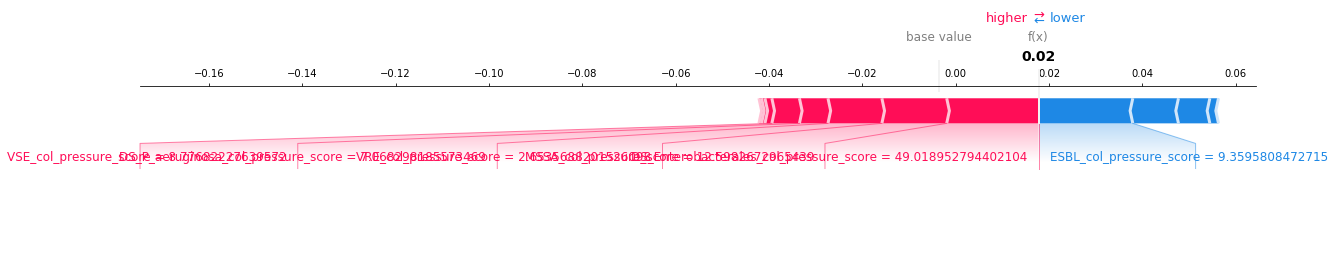

Processing DS_K_pneumoniae
AUC for DS_K_pneumoniae: 0.56


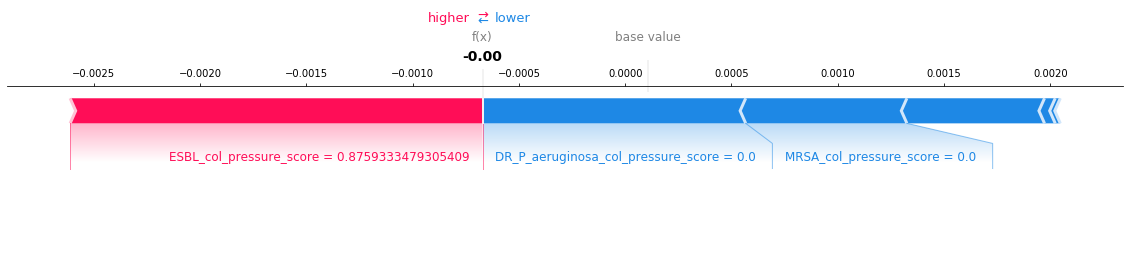

Processing E_coli
AUC for E_coli: 0.57


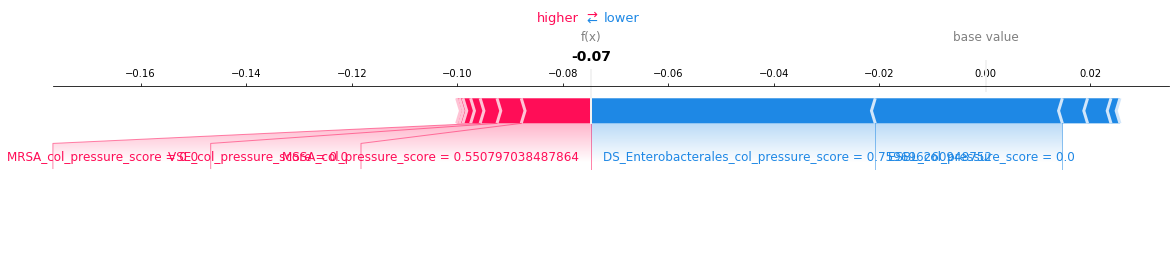

Processing E_faecalis
AUC for E_faecalis: 0.60


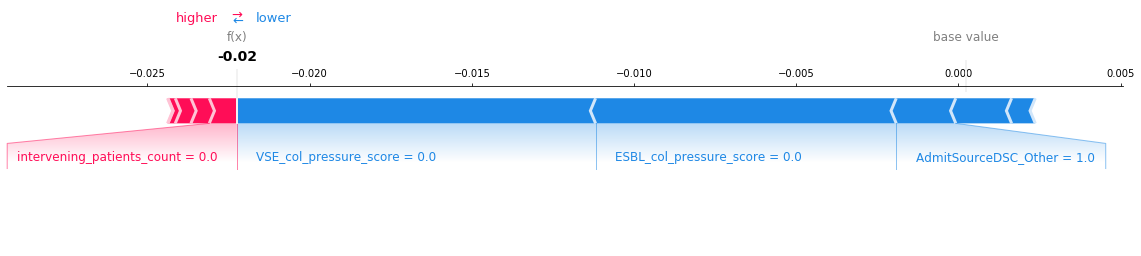

Processing Enteric flora
AUC for Enteric flora: 0.57


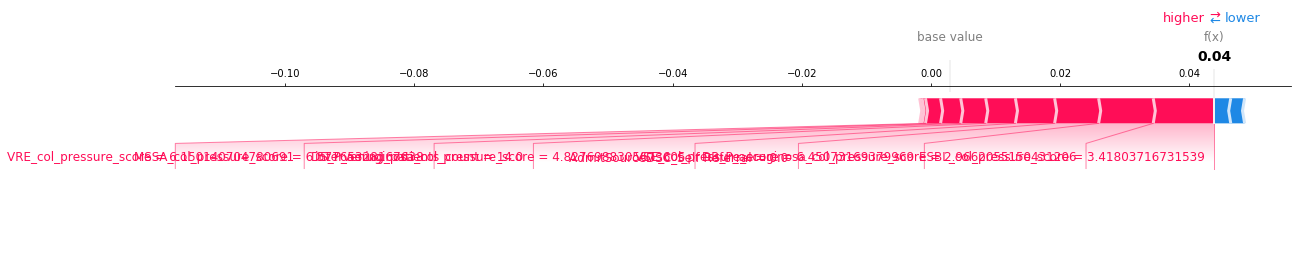

Processing Environmental flora
AUC for Environmental flora: 0.62


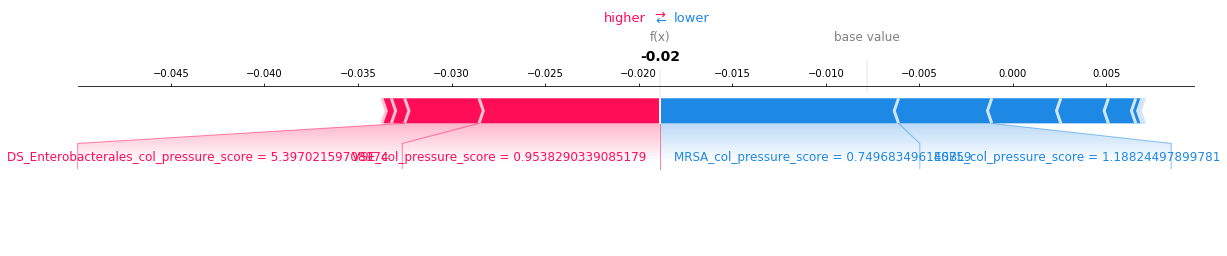

Processing ESBL_E_coli
AUC for ESBL_E_coli: 0.70


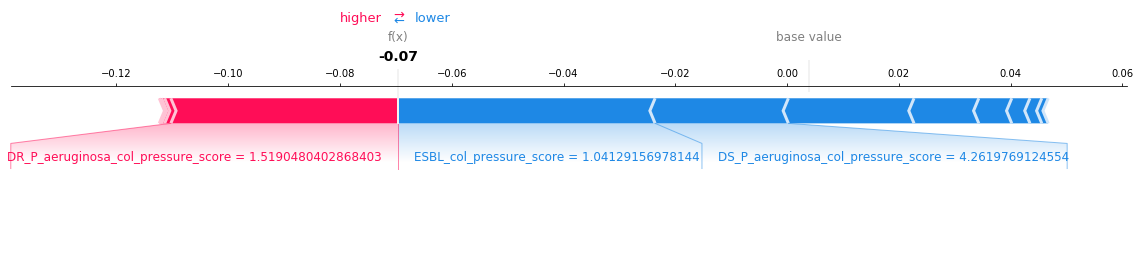

Processing K_pneumoniae
AUC for K_pneumoniae: 0.59


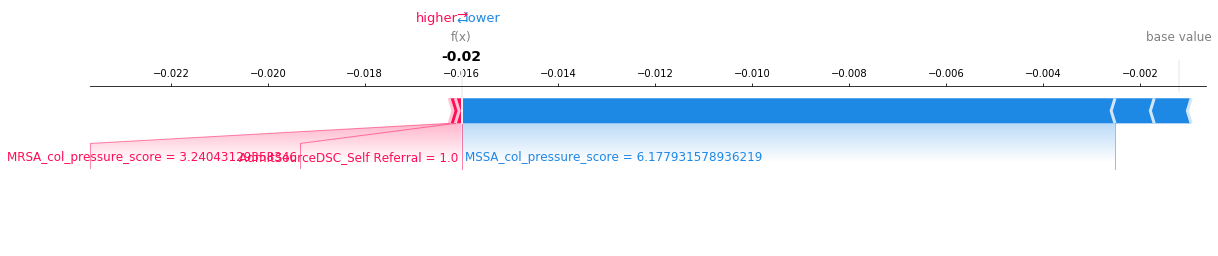

Processing MRSA
AUC for MRSA: 0.61


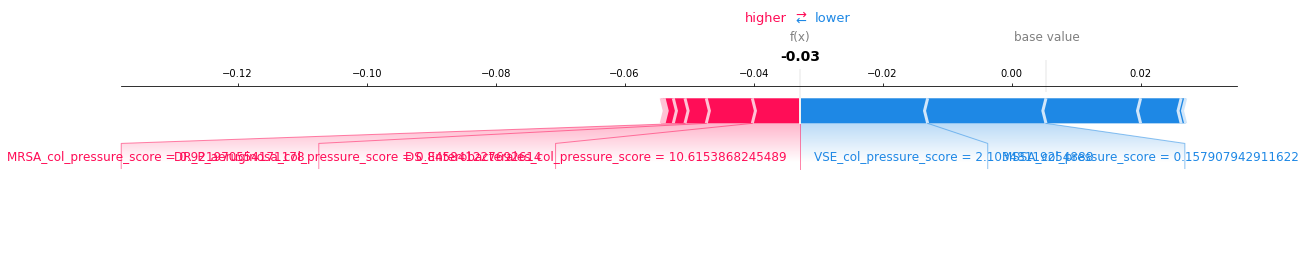

Processing MSSA
AUC for MSSA: 0.72


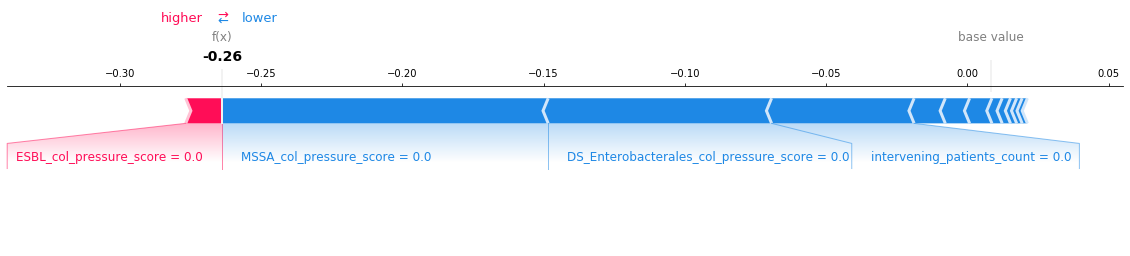

Processing P_aeruginosa
AUC for P_aeruginosa: 0.59


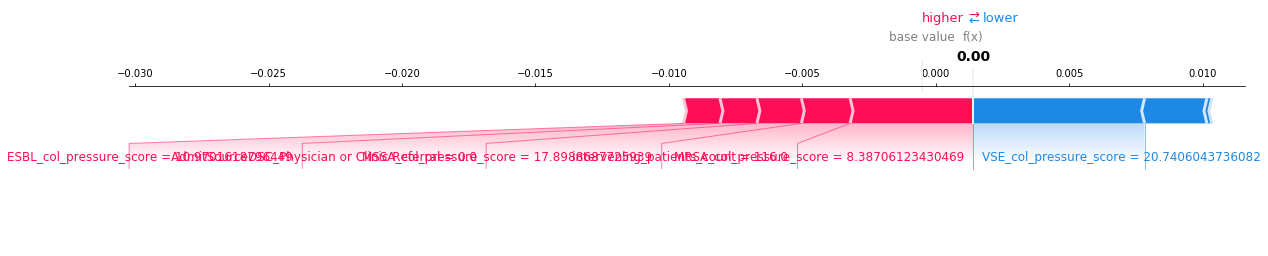

Processing P_mirabilis
AUC for P_mirabilis: 0.57


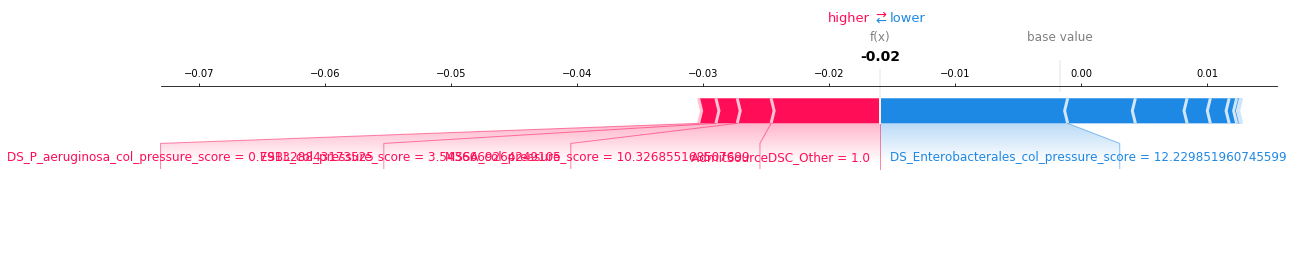

Processing Skin flora
AUC for Skin flora: 0.68


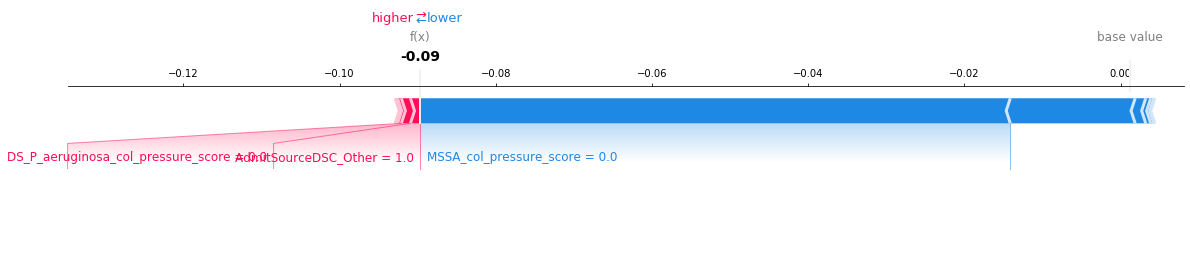

Processing Staph_aureus
AUC for Staph_aureus: 0.68


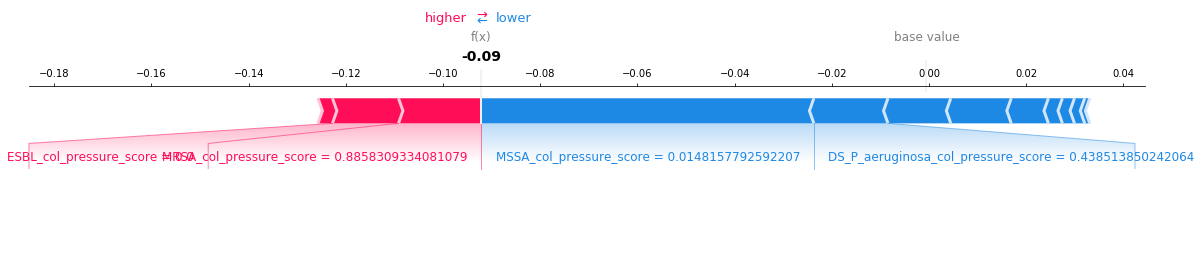

Processing VSE_faecalis
AUC for VSE_faecalis: 0.65


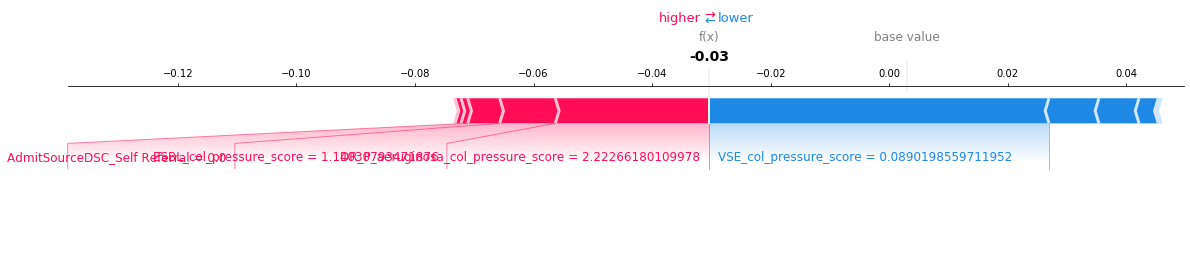

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import eli5
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp

# import data
full_data = pd.read_csv("Results/clean_selection_2024_match.csv")

# Iterate through each unique disease in the target column
for disease in full_data['target'].unique():
    print(f"Processing {disease}")
    # Subset to just one disease target
    target_subset = full_data[full_data['target'] == disease]

    # Define your feature columns; adjust as necessary
    feature_cols = [
        'group_binary', 'intervening_patients_count', 'MRSA_col_pressure_score',
        'VRE_col_pressure_score', 'ESBL_col_pressure_score', 'MSSA_col_pressure_score',
        'VSE_col_pressure_score', 'DS_Enterobacterales_col_pressure_score',
        'DS_P_aeruginosa_col_pressure_score', 'DR_P_aeruginosa_col_pressure_score',
        'AdmitSourceDSC'
    ]

    # Ensure the columns exist in the current subset; adjust as necessary
    columns_exist = [col for col in feature_cols if col in target_subset.columns]
    data = target_subset[columns_exist]

    # shuffle data
    data = data.sample(frac=1).reset_index(drop=True)

    # one-hot encode non-numeric data
    data = pd.get_dummies(data)

    # split into train and test sets
    X = data.drop(columns=["group_binary"])
    y = data["group_binary"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit model
    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])  # calculate the scale_pos_weight value
    model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", max_depth=6, eta=0.01, subsample=0.5, colsample_bytree=0.5, min_child_weight=1, scale_pos_weight=scale_pos_weight)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="auc", early_stopping_rounds=10, verbose=False)

    # evaluate model with AUC
    y_pred = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'AUC for {disease}: {auc_score:.2f}')

    # plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='')
    plt.title(f'ROC Curve for {disease}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(f'ROC_Curve_{disease}.png')
    plt.close()

    # Feature importances
    importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(model.feature_importances_, 3)})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y=importances.index, data=importances)
    plt.title(f'Feature Importances for {disease}')
    plt.tight_layout()
    plt.savefig(f'Results/Importance_plots/Feature_Importances_{disease}.png')
    plt.close()

    # Permutation importance
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    eli5.show_weights(perm, feature_names=X_test.columns.tolist())

    # For each feature of interest, generate partial dependence plots and SHAP values plots
    features_of_interest = ['intervening_patients_count', 'MSSA_col_pressure_score']  # Adjust this list based on your data
    for feature in features_of_interest:
        # Partial dependence plots
        pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature=feature)
        pdp.pdp_plot(pdp_goals, feature)
        plt.title(f'PDP for {feature} - {disease}')
        plt.savefig(f'Results/Importance_plots/PDP_{feature}_{disease}.png')
        plt.close()

        # SHAP values analysis (for selected features only if too many)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.dependence_plot(feature, shap_values, X_test, show=False)
        plt.title(f'SHAP Dependence Plot for {feature} - {disease}')
        plt.savefig(f'Results/Importance_plots/SHAP_{feature}_{disease}.png')
        plt.close()

    # SHAP summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot - {disease}')
    plt.savefig(f'Results/Importance_plots/SHAP_Summary_{disease}.png')
    plt.close()

    # SHAP summary plot detailed
    shap.summary_plot(shap_values, X_test, alpha=.6, show=False)
    plt.title(f'SHAP Detailed Summary - {disease}')
    plt.savefig(f'Results/Importance_plots/SHAP_Detailed_Summary_{disease}.png')
    plt.close()

    # Example of a single prediction's SHAP force plot
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
    plt.savefig(f'Results/Importance_plots/SHAP_Force_{disease}.png')
    plt.close()